In [1]:
# Force garbage collection
import gc
gc.collect()

41

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve

In [29]:
from sklearn.metrics import average_precision_score
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [30]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2


In [135]:
mod_data = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')

In [35]:
def data_prep(data, 
                eval = False,
                eval_year = 2020, 
              area = 'all', 
              wind_speed_threshold = 0, 
              wind_speed_region = ">=",
              wind_direction_range = [0, 360],
              month_list = [1,2,3,4,5,6,7,8,9,10,11,12]):

    # keep human fire
    data['NWCG_CAUSE_CLASSIFICATION'] = data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
    data = data[(data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (data['IS_FIRE'] == 0)]
    
    # convert day to datetime
    data['day'] = pd.to_datetime(data['day'])
   
    # check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        # change day to datetime
        data['day'] = pd.to_datetime(data['day'])
        data['Year'] = data['day'].dt.year

    # ceck if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        # print month column is added in a sentence

    # filter data to be in month_list
    data = data[data['Month'].isin(month_list)]   

    # if it is not evaluation data, then filter the year to be between year-6 and year-1
    if not eval:
        data = data[(data['Year'] >= (eval_year - 6)) & (data['Year'] <= (eval_year - 1))]
        # print after filtering, the min and max year is
        # print('After filtering, the min and max year is:')
        # print(data['Year'].min(), data['Year'].max())
    # if it is evaluation data, ensure the year is eval_year
    else:
        # check the unique values of year
        # print('The unique values of year is:')
        # print(data['Year'].unique())
        # confirm the year is eval_year
        assert data['Year'].unique()[0] == eval_year, 'The year is not equal to eval_year'   

    if area == "south":
        data = data[data['lat'] < 35.75]
    elif area == "north":
        data = data[data['lat'] >= 35.75]

    # filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
    else:
        print('The wind_speed_region is not valid')
    
    #print('The min and max wind speed is:')
    #print(data['wind_speed'].min(), data['wind_speed'].max())

    wind_direction_min, wind_direction_max = wind_direction_range
    if wind_direction_min < wind_direction_max:
        # filter the data to be between wind_direction_min and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
    else: 
        # filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    cat_columns = ['wind_direction_category','veg']
    # check if both cat_columns are in data
    if all(col in data.columns for col in cat_columns):
        data = pd.get_dummies(data, columns=cat_columns)
    elif len([col for col in data.columns if col.startswith('veg_')]) > 0:
        print('veg dummy columns are already in data')
    else:
        print('One of the columns is not in data')

    return data

## Data Study

In [136]:
mod_data['NWCG_CAUSE_CLASSIFICATION'] = mod_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
mod_data = mod_data[(mod_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (mod_data['IS_FIRE'] == 0)]

# only keep south
# mod_data = mod_data[mod_data['lat'] < 35.75]

# add Year column if not exists
if 'Year' not in mod_data.columns:
    # change day to datetime
    mod_data['day'] = pd.to_datetime(mod_data['day'])
    mod_data['Year'] = mod_data['day'].dt.year

# add Month column if not exists
if 'Month' not in mod_data.columns:
    mod_data['Month'] = mod_data['day'].dt.month

In [140]:
mod_big_fire = mod_data[mod_data['min_FIRE_SIZE'] > 10]
# group by Year, sum of IS_FIRE
mod_big_fire.groupby(['Year'])['IS_FIRE'].sum().reset_index()

,Year,IS_FIRE
0,2001,343
1,2002,401
2,2003,392
3,2004,409
4,2005,422
5,2006,453
6,2007,423
7,2008,334
8,2009,229
9,2010,216


In [38]:
mod_data.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_pre_interpolated', 'pdsi_class',
       'max_air_temperature', 'max_relative_humidity', 'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       'wind_from_direction', 'wind_speed', 'wind_direction_category', 'SWE',
       'Band1', 'LAI', 'pdsi', 'IS_FIRE', 'NWCG_CAUSE_CLASSIFICATION',
       'min_FIRE_SIZE', 'max_FIRE_SIZE', 'veg_type_details', 'fire_attribute',
       'veg', 'slope_avg', 'slope_max', 'road_density_km_km2', 'Year',
       'Month'],
      dtype='object')

In [39]:
# group by Year, check # of IS_FIRE == 1
mod_data.groupby('Year')['IS_FIRE'].sum()

Year
2001    1333
2002    1318
2003    1220
2004    1076
2005    2258
2006    2437
2007    2598
2008    1778
2009    1798
2010    1561
2011    1586
2012    1196
2013    1173
2014     838
2015     747
2016    1083
2017    1378
2018    1213
2019    1015
2020    1442
Name: IS_FIRE, dtype: int32

In [42]:
# get quantile of min_FIRE_SIZE from 0.1 to 0.9
mod_data['max_FIRE_SIZE'].quantile([0.8, 0.9, 1])

0.8         0.0
0.9         0.0
1.0    281893.0
Name: max_FIRE_SIZE, dtype: float64

In [45]:
# check distribution of max_FIRE_SIZE when iS_FIRE == 1
mod_data[mod_data['IS_FIRE'] == 1]['max_FIRE_SIZE'].quantile([0.6, 0.8, 0.9, 1])

0.6         0.3
0.8         1.0
0.9         4.0
1.0    281893.0
Name: max_FIRE_SIZE, dtype: float64

In [52]:
# add a column called FIRE_SIZE_CONSISTENCY
mod_data['FIRE_SIZE_CONSISTENCY'] = mod_data['max_FIRE_SIZE'] - mod_data['min_FIRE_SIZE']

In [56]:
mod_data[mod_data['IS_FIRE'] == 1]['FIRE_SIZE_CONSISTENCY'].quantile([0.97, 0.98, 0.99, 0.995, 1])

0.970        0.000
0.980        0.100
0.990        0.900
0.995        2.653
1.000    33423.000
Name: FIRE_SIZE_CONSISTENCY, dtype: float64

In [57]:
mod_data.shape

(3137705, 35)

In [58]:
mod_data_high_confidence = mod_data[mod_data['FIRE_SIZE_CONSISTENCY'] <= 1]

In [59]:
mod_data_high_confidence.shape

(3137470, 35)

In [60]:
# when year = 2007, group by month, check the # of IS_FIRE == 1
mod_data_high_confidence[mod_data_high_confidence['Year'] == 2007].groupby('Month')['IS_FIRE'].sum()

Month
1     227
2     129
3     177
4     170
5     277
6     308
7     366
8     261
9     177
10    251
11    153
12     88
Name: IS_FIRE, dtype: int32

In [61]:
mod_data_high_confidence_fire = mod_data_high_confidence[mod_data_high_confidence['IS_FIRE'] == 1]
mod_data_high_confidence_fire.shape

(28813, 35)

In [66]:
# check the range of wind_from_direction for each wind_direction_category
mod_data_high_confidence_fire.groupby('wind_direction_category')['wind_from_direction'].agg(['min', 'max'])

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\4278175317.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mod_data_high_confidence_fire.groupby('wind_direction_category')['wind_from_direction'].agg(['min', 'max'])


,min,max
wind_direction_category,,
N,1.0,45.0
NE,46.0,90.0
E,91.0,135.0
SE,136.0,180.0
S,181.0,225.0
SW,226.0,270.0
W,271.0,315.0
NW,316.0,360.0


In [68]:
# Define the ranges for each wind direction category
wind_direction_ranges = {
    'N': '1-45°',
    'NE': '46-90°',
    'E': '91-135°',
    'SE': '136-180°',
    'S': '181-225°',
    'SW': '226-270°',
    'W': '271-315°',
    'NW': '316-360°'
}

In [130]:
mod_data_high_confidence_fire.groupby('wind_direction_category')['wind_from_direction'].agg(['min', 'max'])

,min,max
wind_direction_category,,
E,68.0,112.0
N,1.0,360.0
NE,23.0,67.0
NW,293.0,337.0
S,158.0,202.0
SE,113.0,157.0
SW,203.0,247.0
W,248.0,292.0


In [126]:
wind_direction_ranges = {
    'N': (337.5, 22.5),
    'NE': (22.5, 67.5),
    'E': (67.5, 112.5),
    'SE': (112.5, 157.5),
    'S': (157.5, 202.5),
    'SW': (202.5, 247.5),
    'W': (247.5, 292.5),
    'NW': (292.5, 337.5)
}

In [129]:
# reassign wind_direction_category baesd on wind_direction_ranges
def assign_wind_direction_category(row):
    if 337.5 <= row['wind_from_direction'] <= 360 or 0 <= row['wind_from_direction'] < 22.5:
        return 'N'
    for category, (min_angle, max_angle) in wind_direction_ranges.items():
        if min_angle <= row['wind_from_direction'] < max_angle:
            return category
    return None

mod_data_high_confidence_fire['wind_direction_category'] = mod_data_high_confidence_fire.apply(assign_wind_direction_category, axis=1)

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\1858539762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data_high_confidence_fire['wind_direction_category'] = mod_data_high_confidence_fire.apply(assign_wind_direction_category, axis=1)


In [133]:
# order the wind_direction_category from N to NW
wind_direction_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
mod_data_high_confidence_fire['wind_direction_category'] = pd.Categorical(mod_data_high_confidence_fire['wind_direction_category'], categories=wind_direction_order, ordered=True)

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\885347816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data_high_confidence_fire['wind_direction_category'] = pd.Categorical(mod_data_high_confidence_fire['wind_direction_category'], categories=wind_direction_order, ordered=True)


C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\804860814.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = mod_data_high_confidence_fire.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)


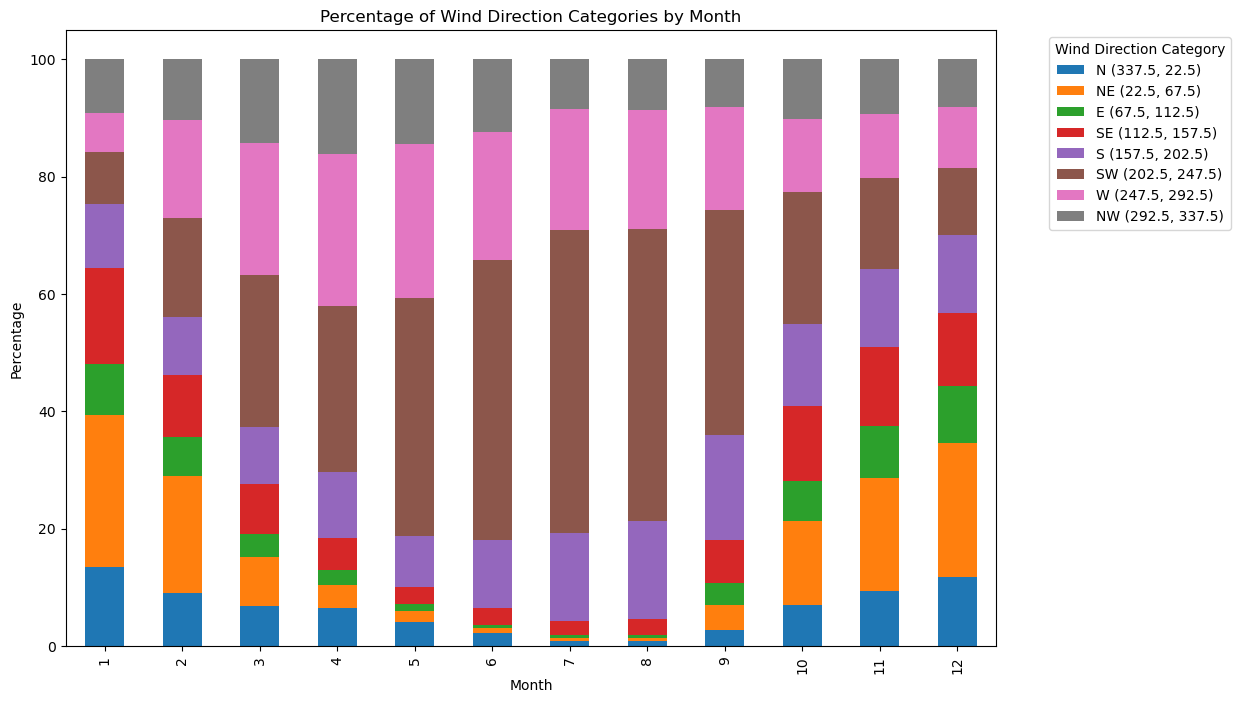

In [134]:
# Calculate the percentage of each wind direction category for each month
percentage_df = mod_data_high_confidence_fire.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

# Plot the results
ax = percentage_df.plot(kind='bar', stacked=True, figsize=(12, 8))

# Update the legend labels to include the ranges
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} {wind_direction_ranges[label]}' for label in labels]
ax.legend(handles, new_labels, title='Wind Direction Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add titles and labels
plt.title('Percentage of Wind Direction Categories by Month')
plt.xlabel('Month')
plt.ylabel('Percentage')

# Show the plot
plt.show()

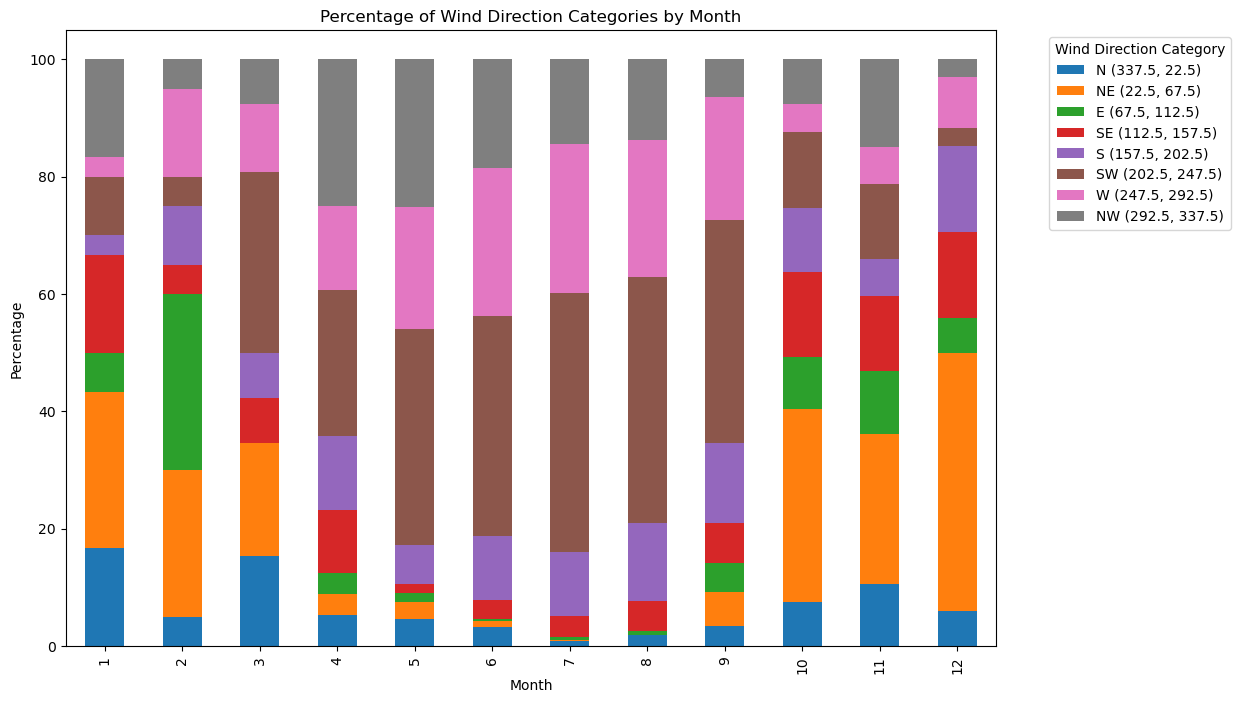

In [142]:
# Loop through each year and generate the plot
for year in mod_data_high_confidence_fire['Year'].unique():
    # Filter data for the current year
    data_year = mod_data_high_confidence_fire[mod_data_high_confidence_fire['Year'] == year]

    # Calculate the percentage of each wind direction category for each month
    percentage_df = data_year.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)
    percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

    # Plot the results
    ax = percentage_df.plot(kind='bar', stacked=True, figsize=(20, 8))

    # Update the legend labels to include the ranges
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [f'{label} {wind_direction_ranges[label]}' for label in labels]
    ax.legend(handles, new_labels, title='Wind Direction Category', bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol = 4)

    # Add titles and labels
    plt.xlabel('Month')
    plt.ylabel('Percentage')

    # Save the plot
    plt.savefig(f'../Plot/Wind_Direction_8/wind_direction_percentage_{year}.png')

    # Close the plot to avoid overlap
    plt.close()

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\3977982757.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = data_year.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)
C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\3977982757.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = data_year.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)
C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\3977982757.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of

In [73]:
# add a column called wind_direction_category_v2: wind_from_direction between 0 and 100 or equal to 360 is "0-100", otherwise "100-359"
mod_data_high_confidence_fire['wind_direction_category_v2'] = np.where((mod_data_high_confidence_fire['wind_from_direction'] <= 100) | (mod_data_high_confidence_fire['wind_from_direction'] == 360), '0-100', '100-359')
mod_data_high_confidence_fire['wind_direction_category_v2'].value_counts()

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\211748901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data_high_confidence_fire['wind_direction_category_v2'] = np.where((mod_data_high_confidence_fire['wind_from_direction'] <= 100) | (mod_data_high_confidence_fire['wind_from_direction'] == 360), '0-100', '100-359')


wind_direction_category_v2
100-359    25756
0-100       3057
Name: count, dtype: int64

In [74]:
# check the range of wind_from_direction for each wind_direction_category_v2
mod_data_high_confidence_fire.groupby('wind_direction_category_v2')['wind_from_direction'].agg(['min', 'max'])

,min,max
wind_direction_category_v2,,
0-100,1.0,360.0
100-359,101.0,359.0


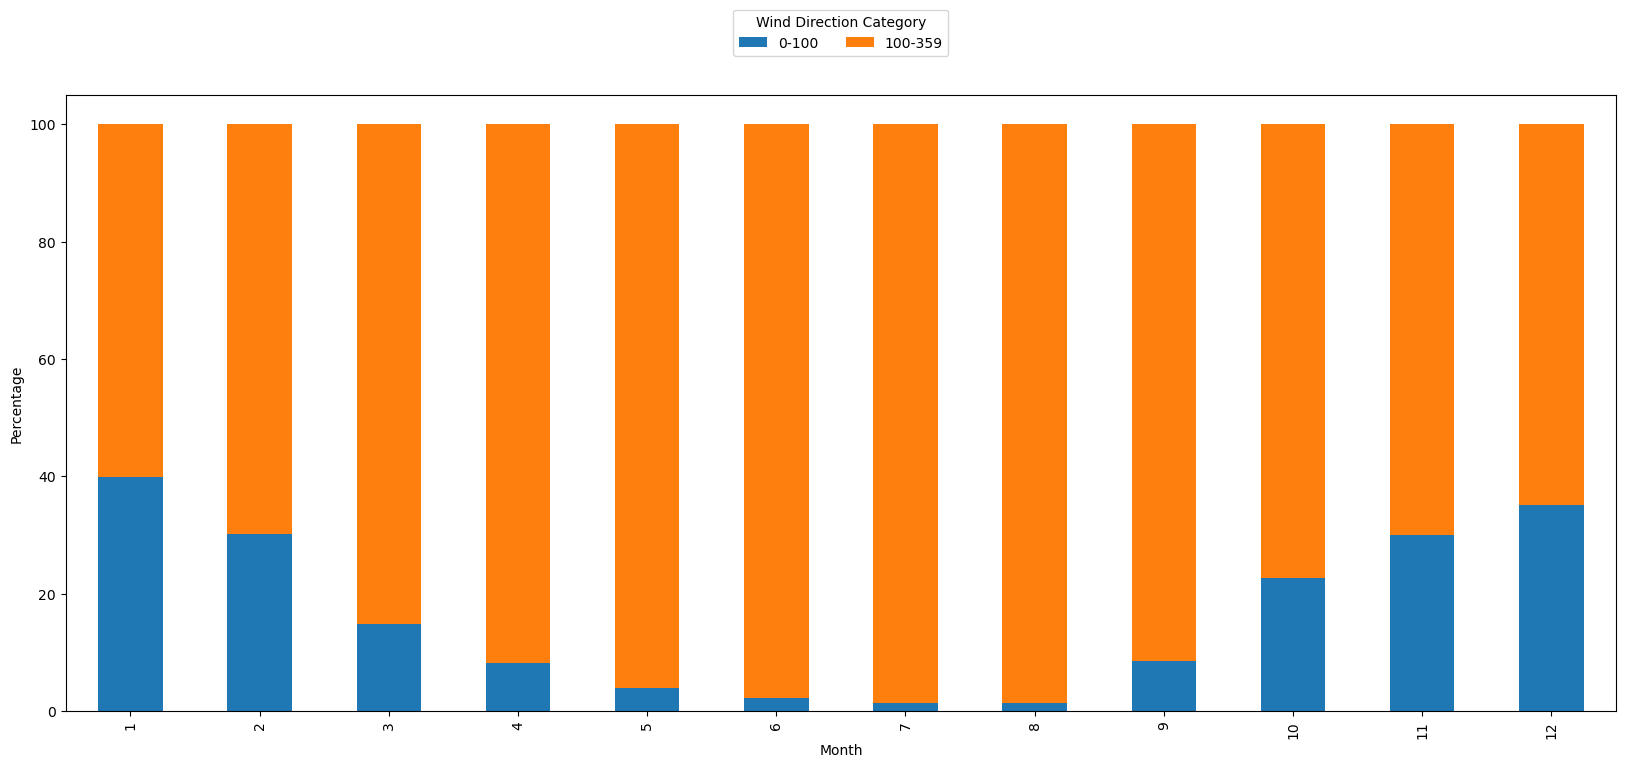

In [95]:
percentage_df = mod_data_high_confidence_fire.groupby(['Month', 'wind_direction_category_v2']).size().unstack(fill_value=0) 
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

percentage_df.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Month') 
plt.ylabel('Percentage') 

plt.legend(title='Wind Direction Category', bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol = 2)

plt.show()

In [124]:
mod_data_high_confidence_fire_2012 = mod_data_high_confidence_fire[mod_data_high_confidence_fire['Year'] == 2012]
mod_data_high_confidence_fire_2012.shape

(1190, 36)

In [121]:
# check max of max_FIRE_SIZE in mod_data_high_confidence_fire_2007
mod_data_high_confidence_fire_2007['max_FIRE_SIZE'].quantile([0.97, 0.99, 1])

0.97        20.00
0.99       501.43
1.00    240207.00
Name: max_FIRE_SIZE, dtype: float64

In [125]:
# check # of rows that have mx_FIRE_SIZE > 100
mod_data_high_confidence_fire_2012[mod_data_high_confidence_fire_2012['max_FIRE_SIZE'] > 100].groupby('Month')['IS_FIRE'].sum()

Month
5      2
6     11
7      6
8      4
9      3
11     1
Name: IS_FIRE, dtype: int32

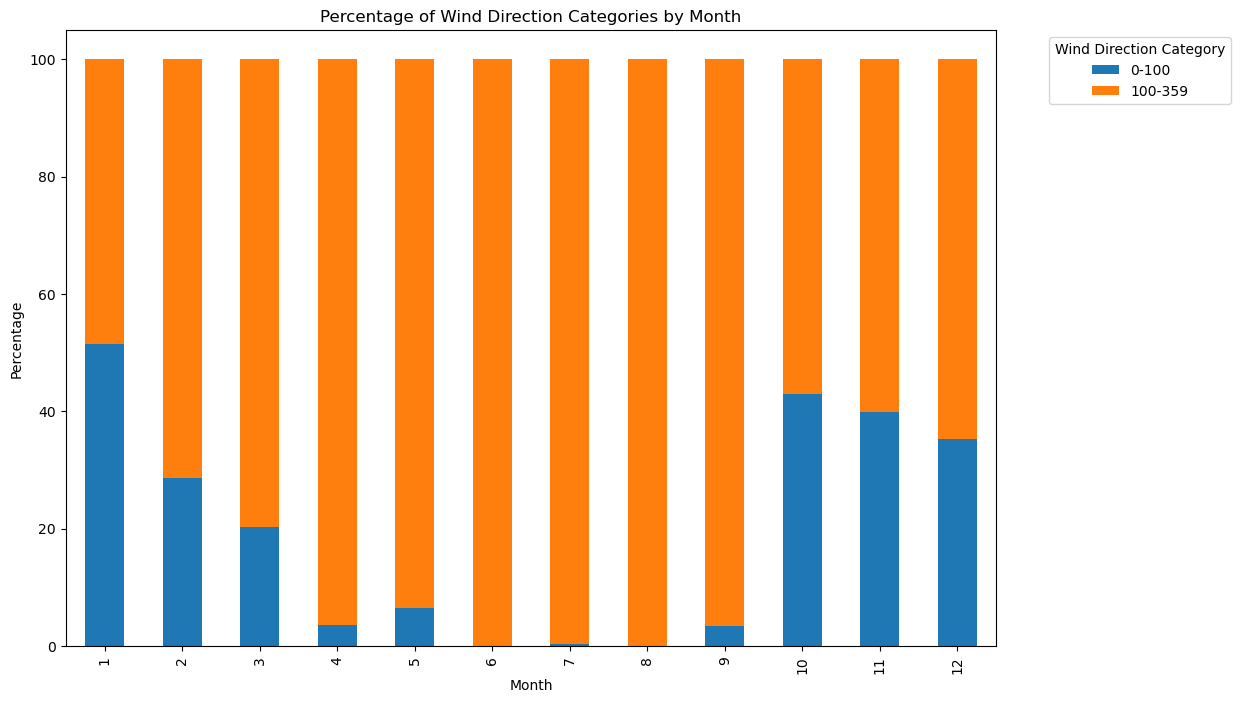

In [86]:
percentage_df = mod_data_high_confidence_fire_2007.groupby(['Month', 'wind_direction_category_v2']).size().unstack(fill_value=0) 
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

percentage_df.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of Wind Direction Categories by Month') 
plt.xlabel('Month') 
plt.ylabel('Percentage') 
plt.legend(title='Wind Direction Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [100]:
# group by Year and Month, get count()
mod_data_high_confidence_fire.groupby(['Year', 'Month']).size().unstack(fill_value=0)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,61,14,18,24,160,239,245,184,148,132,63,32
2002,49,105,89,99,162,198,180,147,117,80,64,19
2003,55,17,28,21,132,170,261,197,139,113,31,45
2004,31,32,43,93,166,140,218,135,122,51,14,21
2005,21,32,34,118,259,349,472,330,255,136,133,92
2006,125,135,50,48,208,380,446,299,239,174,137,172
2007,227,129,177,170,277,308,366,261,177,251,153,88
2008,54,37,84,170,205,260,249,162,164,199,134,43
2009,73,44,64,142,213,230,312,229,185,121,133,45


In [96]:
# plot this foe each year and save the plot
years = mod_data_high_confidence_fire['Year'].unique()
for year in years:
    mod_data_high_confidence_fire_year = mod_data_high_confidence_fire[mod_data_high_confidence_fire['Year'] == year]
    percentage_df = mod_data_high_confidence_fire_year.groupby(['Month', 'wind_direction_category_v2']).size().unstack(fill_value=0) 
    percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

    percentage_df.plot(kind='bar', stacked=True, figsize=(16, 8))

    #plt.title(f'Percentage of Wind Direction Categories by Month - {year}') 
    plt.xlabel('Month') 
    plt.ylabel('Percentage') 
    plt.legend(title='Wind Direction Category', bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol = 2)

    plt.savefig(f'../Plot/Wind_Direction/wind_direction_0_100_percentage_{year}.png')
    plt.close()

In [82]:
mod_data_high_confidence_fire['max_FIRE_SIZE'].quantile([0.6, 0.8, 0.9, 0.95,1])

0.60         0.300
0.80         1.000
0.90         3.594
0.95        15.000
1.00    281893.000
Name: max_FIRE_SIZE, dtype: float64

In [143]:
mod_data_high_confidence_fire_big = mod_data_high_confidence_fire[mod_data_high_confidence_fire['max_FIRE_SIZE'] >= 10]
mod_data_high_confidence_fire_big.shape

(1787, 36)

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\1569057197.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = mod_data_high_confidence_fire_big.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)


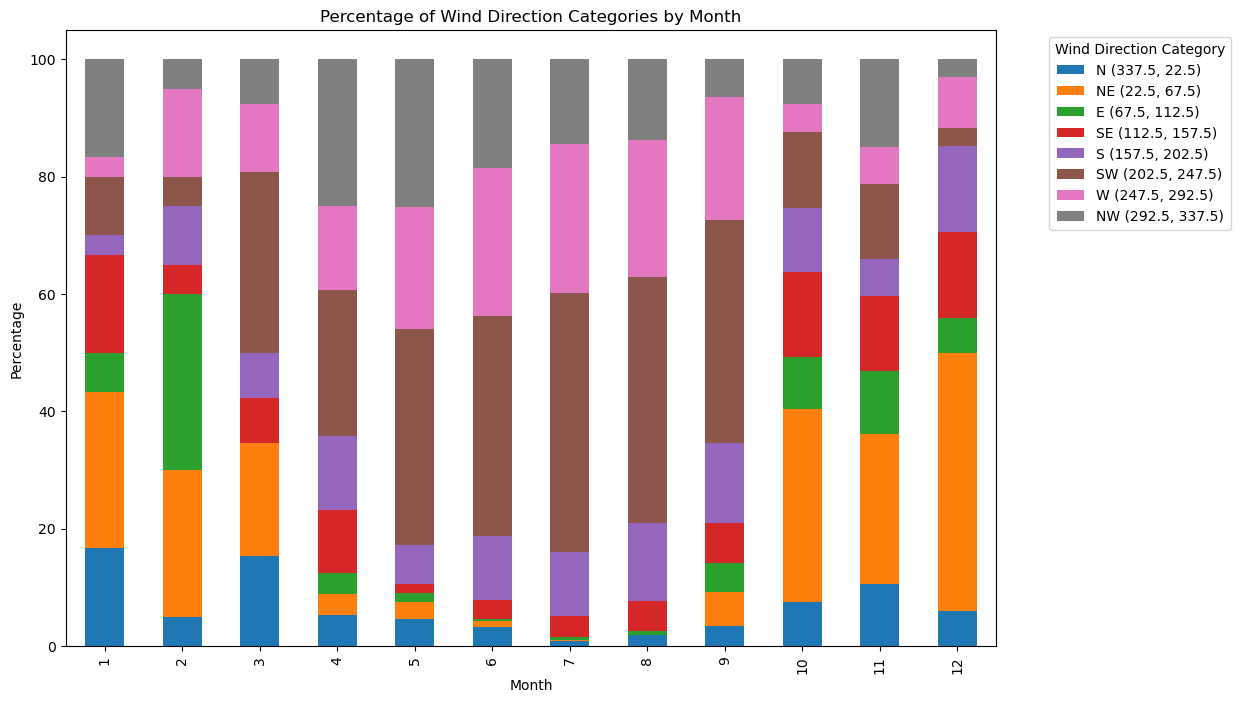

In [144]:
# Calculate the percentage of each wind direction category for each month
percentage_df = mod_data_high_confidence_fire_big.groupby(['Month', 'wind_direction_category']).size().unstack(fill_value=0)
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

# Plot the results
ax = percentage_df.plot(kind='bar', stacked=True, figsize=(12, 8))

# Update the legend labels to include the ranges
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} {wind_direction_ranges[label]}' for label in labels]
ax.legend(handles, new_labels, title='Wind Direction Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add titles and labels
plt.title('Percentage of Wind Direction Categories by Month')
plt.xlabel('Month')
plt.ylabel('Percentage')

# Show the plot
plt.show()

In [113]:
# filter year to be 2021
mod_data_high_confidence_fire_big_2012 = mod_data_high_confidence_fire_big[mod_data_high_confidence_fire_big['Year'] == 2012]
mod_data_high_confidence_fire_big_2012.shape

(28, 36)

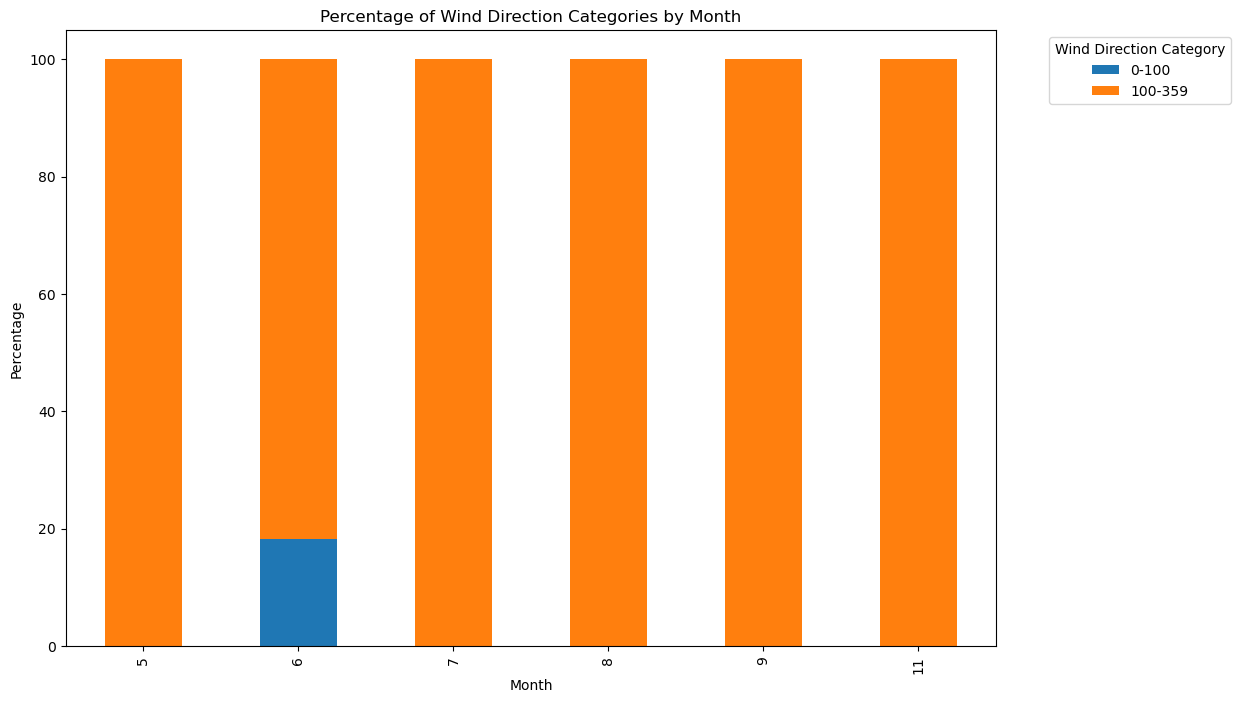

In [114]:
percentage_df = mod_data_high_confidence_fire_big_2012.groupby(['Month', 'wind_direction_category_v2']).size().unstack(fill_value=0) 
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

percentage_df.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of Wind Direction Categories by Month') 
plt.xlabel('Month') 
plt.ylabel('Percentage') 
plt.legend(title='Wind Direction Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

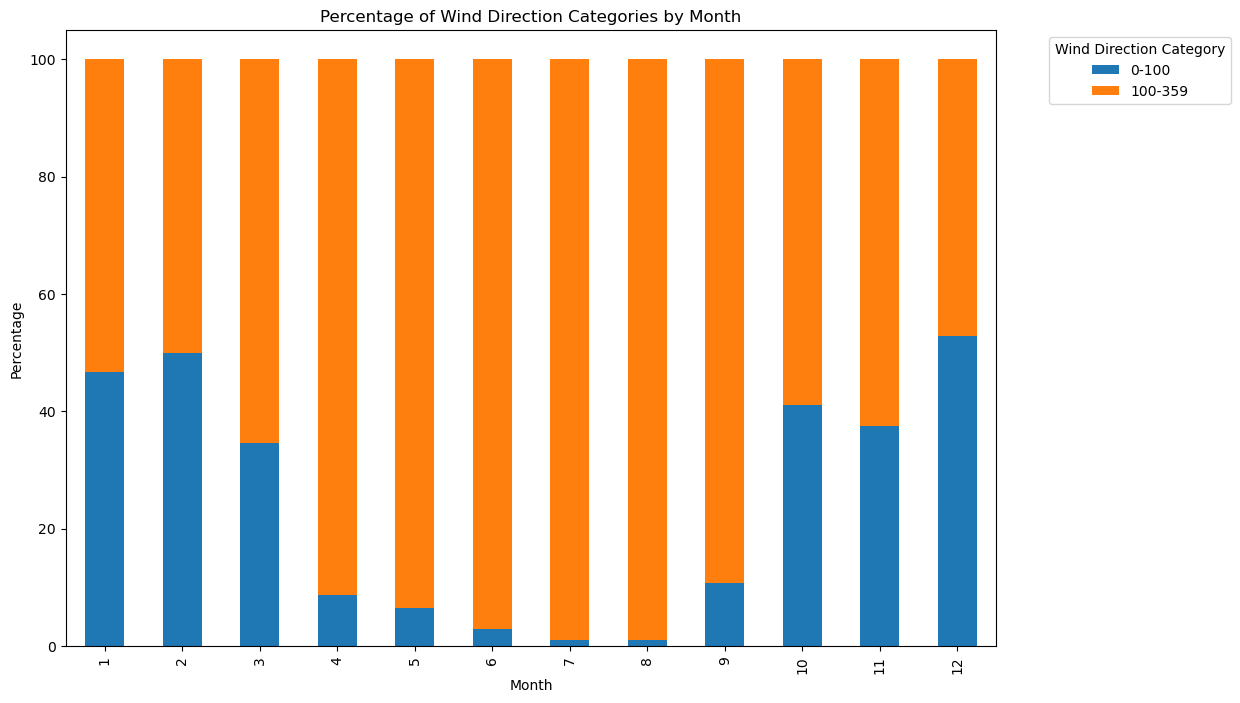

In [84]:
percentage_df = mod_data_high_confidence_fire_big.groupby(['Month', 'wind_direction_category_v2']).size().unstack(fill_value=0) 
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

percentage_df.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of Wind Direction Categories by Month') 
plt.xlabel('Month') 
plt.ylabel('Percentage') 
plt.legend(title='Wind Direction Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
wind_direction_ranges = {
    'N': (337.5, 22.5),
    'NE': (22.5, 67.5),
    'E': (67.5, 112.5),
    'SE': (112.5, 157.5),
    'S': (157.5, 202.5),
    'SW': (202.5, 247.5),
    'W': (247.5, 292.5),
    'NW': (292.5, 337.5)
}

## Example: Year 2007

In [145]:
yr = 2007

In [146]:
# read '../Clean_Data/Model_Data/Evaluation/Predictions/{yr}_predictions.csv'
pred = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Predictions/{yr}_predictions.csv')

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_19736\1568142160.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  pred = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Predictions/{yr}_predictions.csv')


In [147]:
model_path = f'../Model/predict_{yr}_6yr_model.json'
mod = xgb.Booster()
mod.load_model(model_path)

In [148]:
month_list_map = {'north': [1,10,11,12], 
                  'south': [10,11,12,1,2,3]}
#wind_direction_range_map = {'north': [315, 90],
                            #'south': [360, 100]}

In [149]:
def data_filter(data, eval_year = 2020, 
              area = 'all', 
              wind_speed_threshold = 0, 
              wind_speed_region = ">=",
              wind_direction_range = [0, 360],
              month_list = [1,2,3,4,5,6,7,8,9,10,11,12]):
    
    # convert day to datetime
    data['day'] = pd.to_datetime(data['day'])
   
    # check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        # change day to datetime
        data['day'] = pd.to_datetime(data['day'])
        data['Year'] = data['day'].dt.year

    assert data['Year'].unique()[0] == eval_year, 'The year is not equal to eval_year'

    # ceck if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        # print month column is added in a sentence

    # filter data to be in month_list
    data = data[data['Month'].isin(month_list)]      

    if area == "south":
        data = data[data['lat'] < 35.75]
    elif area == "north":
        data = data[data['lat'] >= 35.75]

    # filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
    else:
        print('The wind_speed_region is not valid')
    
    #print('The min and max wind speed is:')
    #print(data['wind_speed'].min(), data['wind_speed'].max())

    wind_direction_min, wind_direction_max = wind_direction_range
    if wind_direction_min < wind_direction_max:
        # filter the data to be between wind_direction_min and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
    else: 
        # filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    return data

In [150]:
mod_data['NWCG_CAUSE_CLASSIFICATION'] = mod_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
mod_data = mod_data[(mod_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (mod_data['IS_FIRE'] == 0)]

train_dat = data_prep(mod_data, eval_dat=False, 
                      eval_year = 2007, area = 'south',
                       month_list=month_list_map["south"])

TypeError: data_prep() got an unexpected keyword argument 'eval_dat'

In [151]:
Eval_area_wind = data_filter(pred,
                            eval_year=2007, 
                            area = "south",
                            month_list=month_list_map["south"]
                            )

In [19]:
train_dat['NWCG_CAUSE_CLASSIFICATION'].unique()

array(['None', "'Human'",
       "'Human', 'Missing data/not specified/undetermined'",
       "'Human', 'Natural'"], dtype=object)

In [152]:
import shap

In [153]:
# filter only the fire data
Eval_area_wind_fire = Eval_area_wind[Eval_area_wind['predictions_binary'] == 1]
Eval_area_wind_fire.shape

(538, 59)

In [21]:
train_dat_fire = train_dat[train_dat['IS_FIRE'] == 1]
train_dat_fire.shape

(3865, 57)

In [22]:
explainer = shap.Explainer(mod)
shap_values = explainer(train_dat_fire[mod.feature_names])

In [157]:
shap_values = explainer(Eval_area_wind[mod.feature_names])
shap.plots.bar(shap_values, max_display = 50)

KeyboardInterrupt: 

In [154]:
explainer = shap.Explainer(mod)
shap_values = explainer(Eval_area_wind_fire[mod.feature_names])

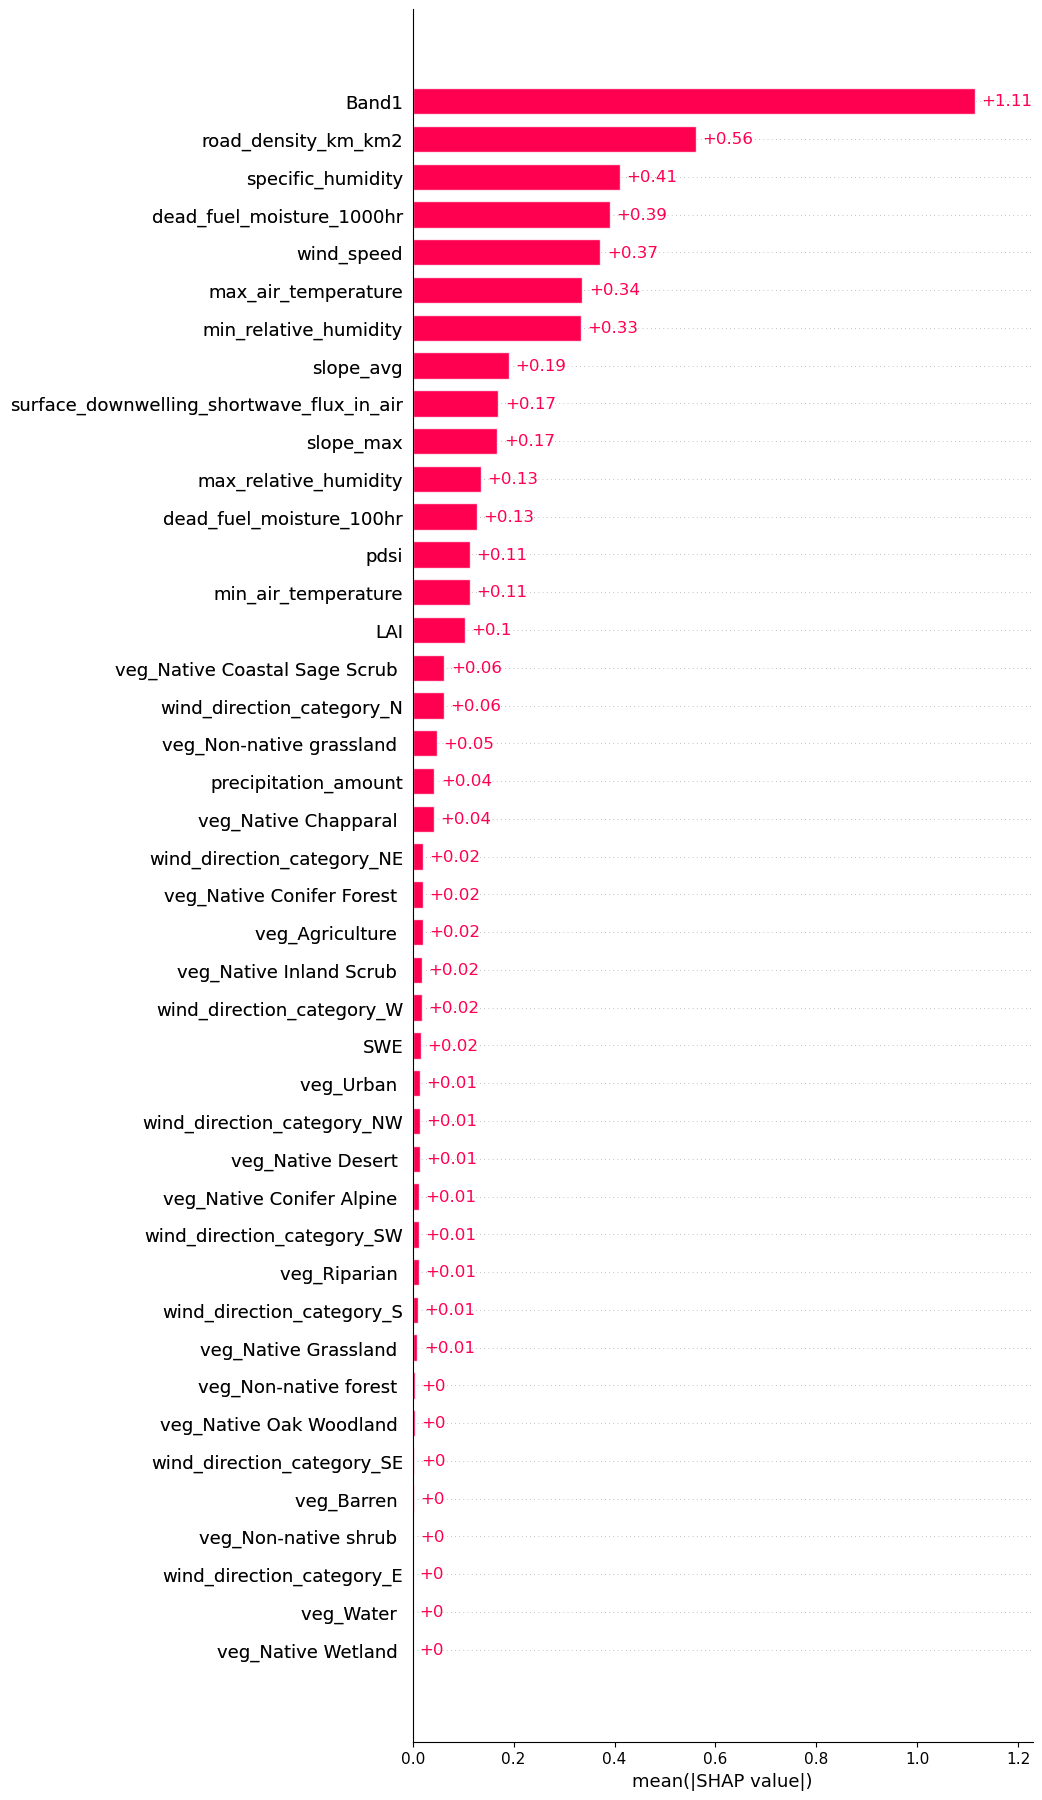

In [156]:
shap.plots.bar(shap_values, max_display = 50)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


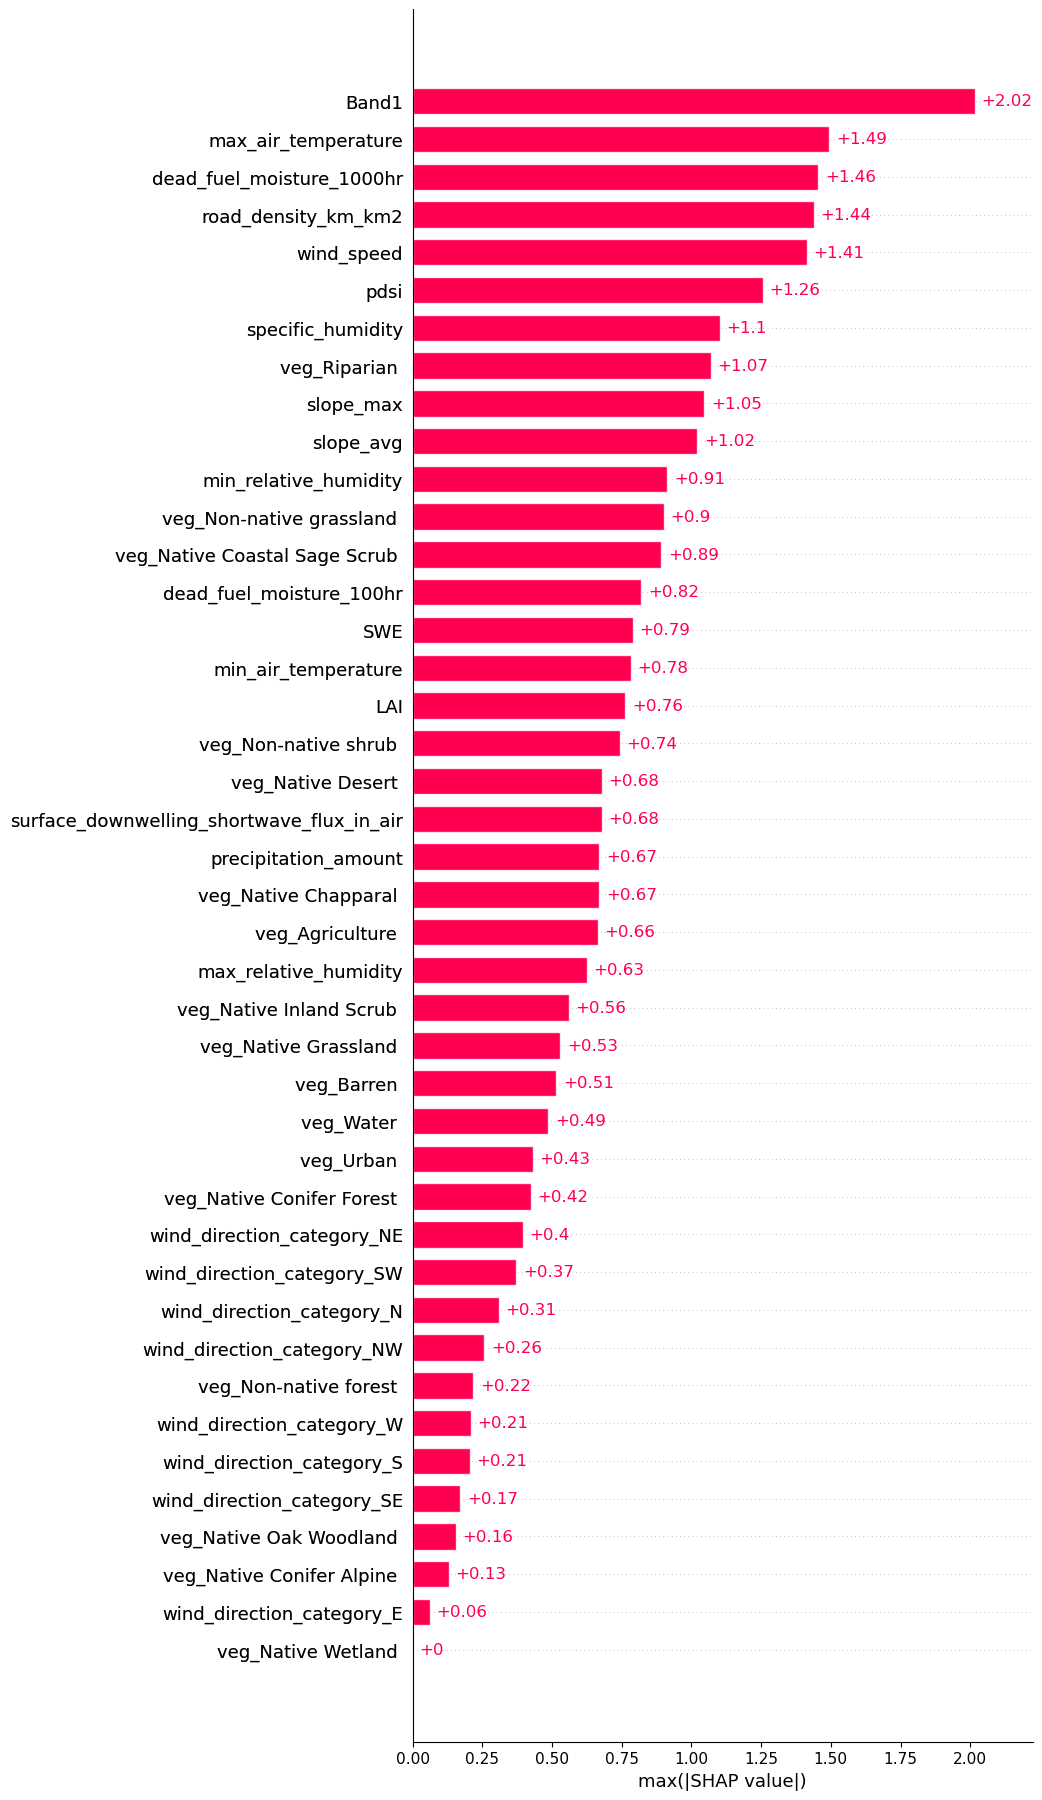

In [25]:
shap.plots.bar(shap_values.abs.max(0), max_display = 50)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


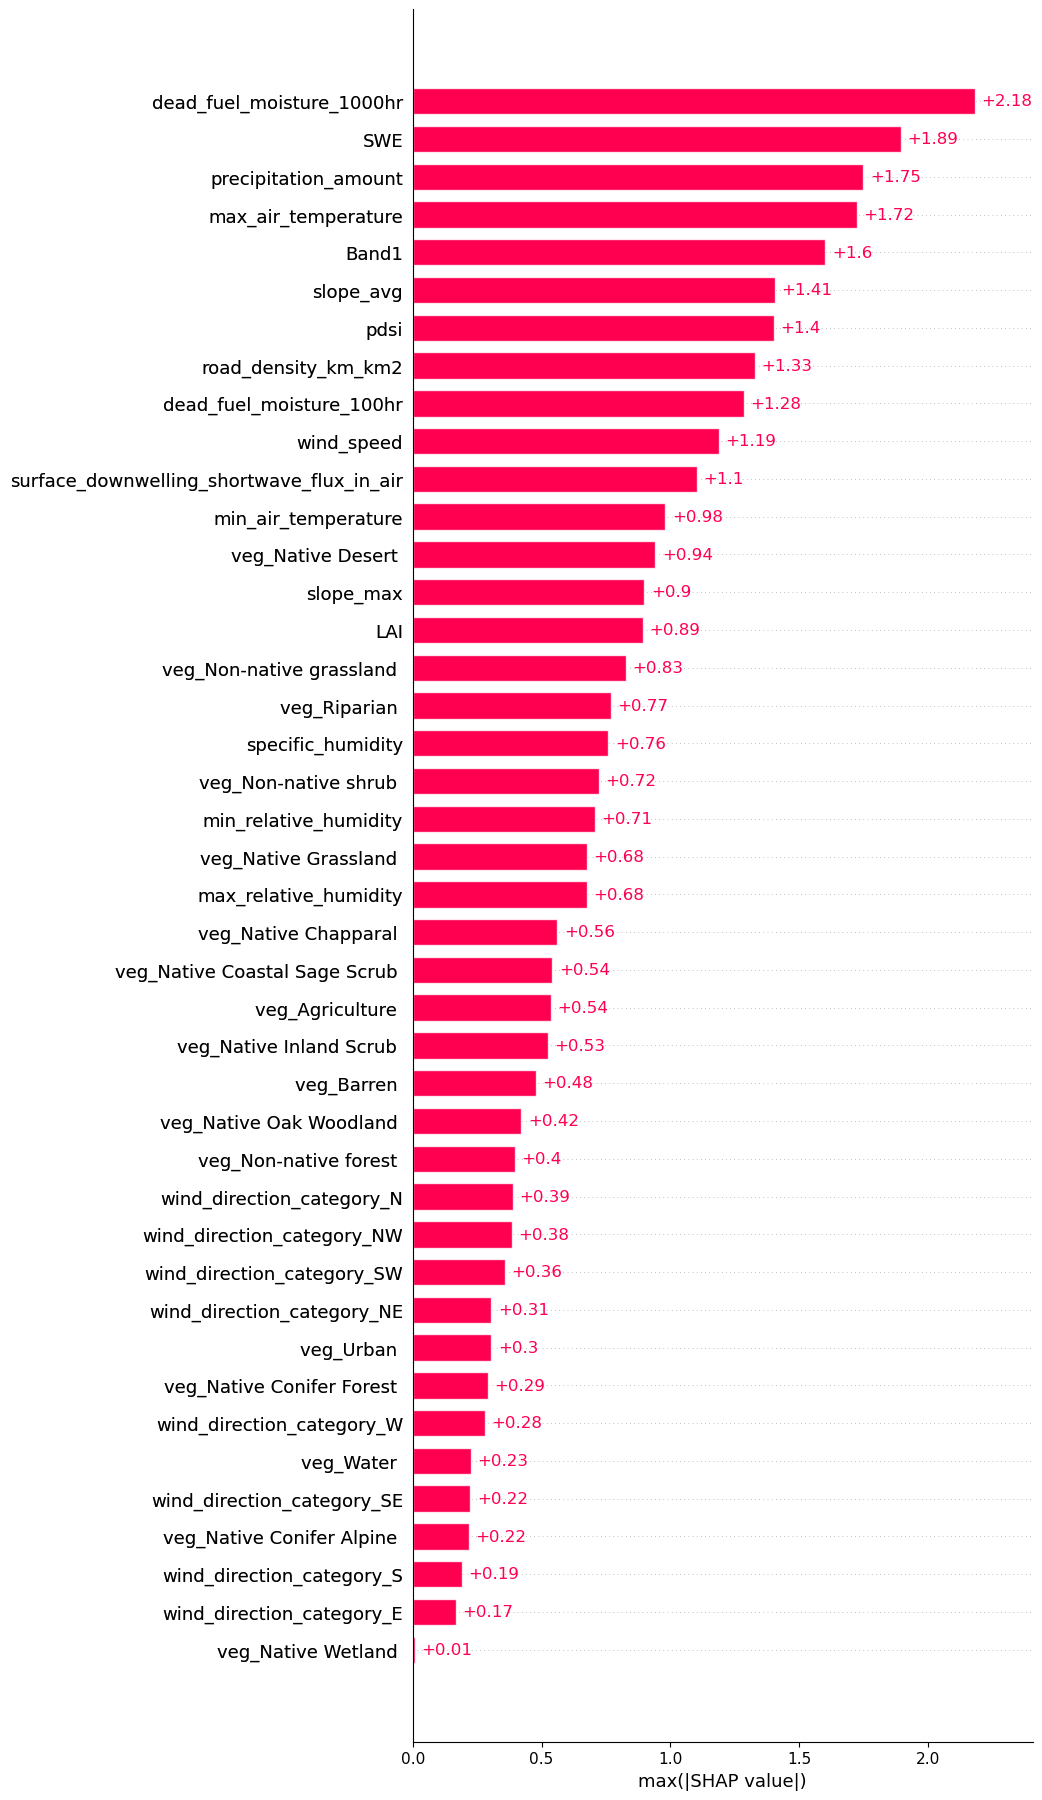

In [26]:
train_dat_no_fire = train_dat[train_dat['IS_FIRE'] == 0]
train_dat_no_fire = train_dat_no_fire.sample(n =10000, random_state = 42)

# plot the shap values for the no fire data
shap_values_no_fire = explainer(train_dat_no_fire[mod.feature_names])
shap.plots.bar(shap_values_no_fire.abs.max(0), max_display = 50)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


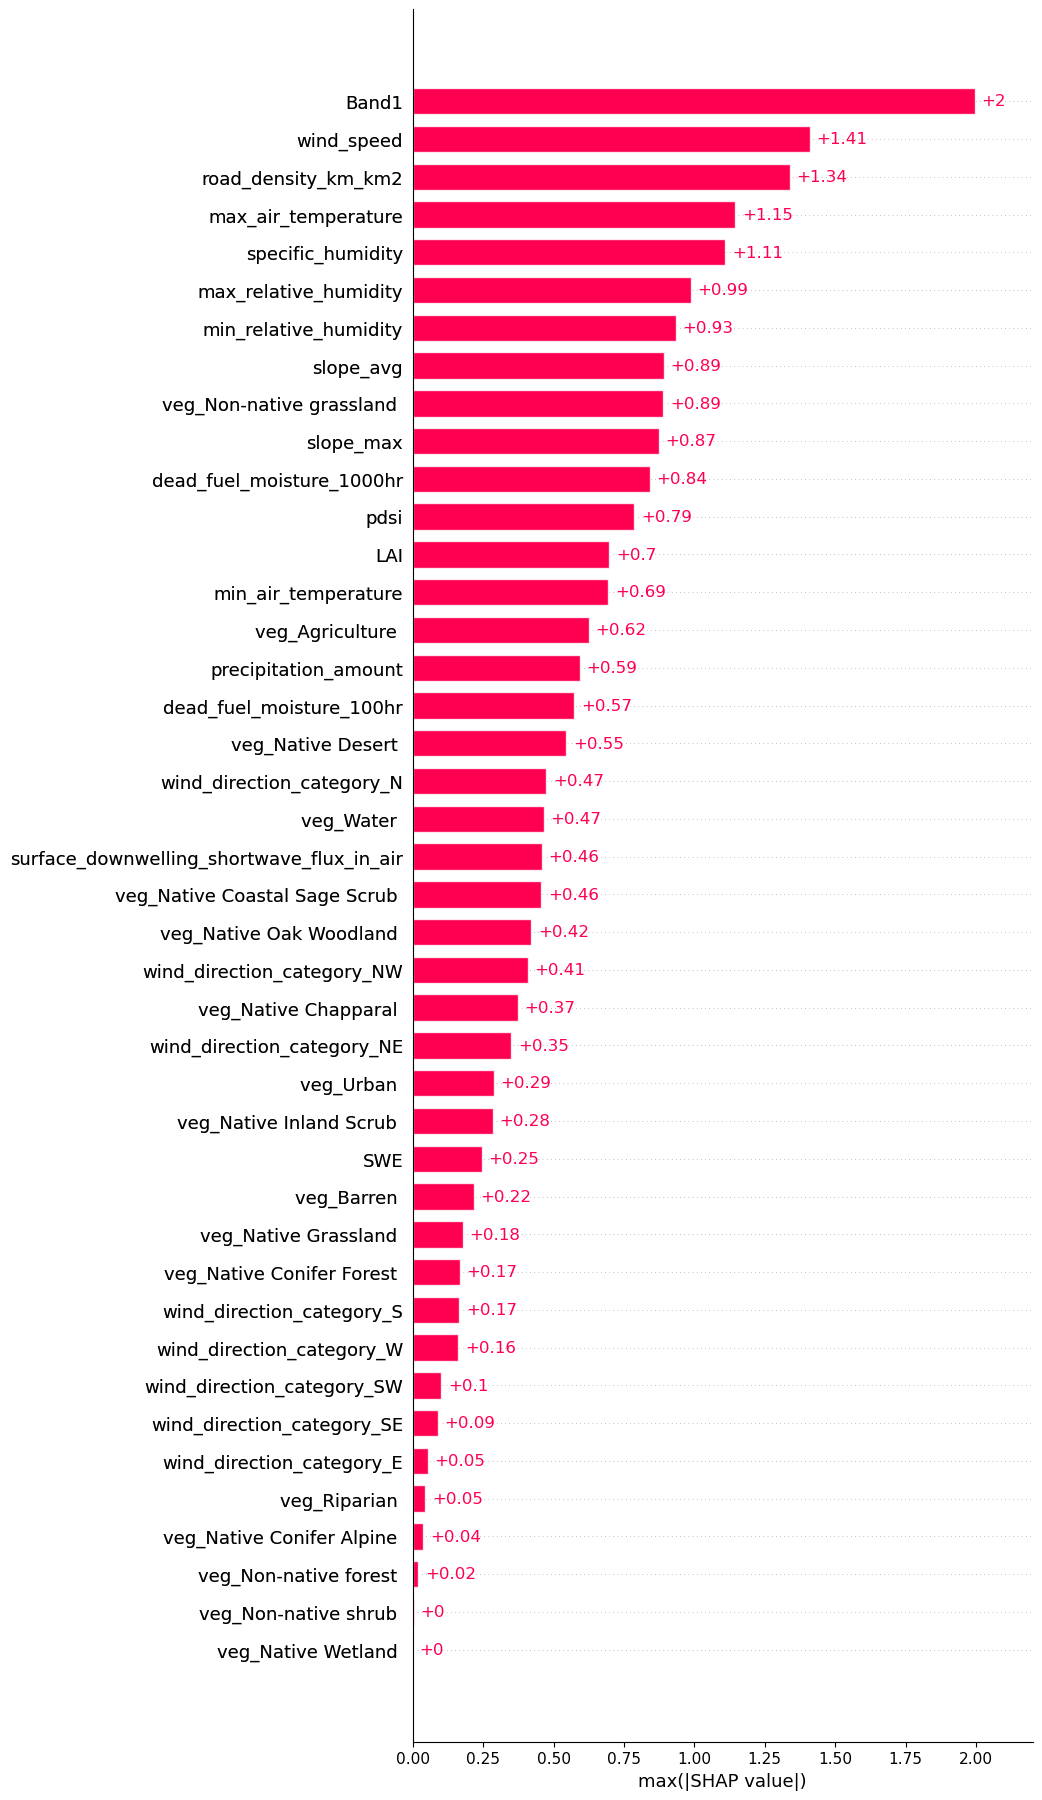

In [37]:
shap.plots.bar(shap_values.abs.max(0), max_display = 50)

In [ ]:
years = range(2007, 2021)

results_eval_only = []

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * len([">=", "<"])

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years, areas, and wind conditions") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['prediction'] = mod.predict(dmatrix_eval)

        for area in ['south', 'north']:
            for wind_condition in [">=","<"]:
                Eval_area_wind = data_filter(Eval_data, 
                                    eval_year=yr, 
                                    area = area, 
                                    wind_speed_threshold=6, 
                                    wind_speed_region=wind_condition,
                                    wind_direction_range=wind_direction_range_map[area], 
                                    month_list=month_list_map[area]
                                    )
                if Eval_area_wind['IS_FIRE'].sum() == 0:
                    results.append([yr, area, wind_condition, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
                else:
                    roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15 = evaluate_model_v2(Eval_area_wind, "prediction", 'IS_FIRE', threshold=0.2)
                    results_eval_only.append([yr, area, wind_condition, roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15])
    
                # clean the cache
                gc.collect()

                # Update the progress bar
                pbar.update(1)

Processing years, areas, and wind conditions: 100%|██████████| 56/56 [05:15<00:00,  5.63s/it]


In [85]:
years = range(2007, 2021)

results_eval_only_v2 = []

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * len([">=", "<"])

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years, areas, and wind conditions") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['prediction'] = mod.predict(dmatrix_eval)

        for area in ['south', 'north']:
            for wind_condition in [">=","<"]:
                Eval_area_wind = data_filter(Eval_data, 
                                    eval_year=yr, 
                                    area = area, 
                                    wind_speed_threshold=6, 
                                    wind_speed_region=wind_condition,
                                    wind_direction_range=wind_direction_range_map[area], 
                                    month_list=month_list_map[area]
                                    )
                if Eval_area_wind['IS_FIRE'].sum() == 0:
                    results_eval_only_v2.append([yr, area, wind_condition, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
                else:
                    roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15 = evaluate_model_v2(Eval_area_wind, "prediction", 'IS_FIRE', auto_adjust_cutoff=True)
                    results_eval_only_v2.append([yr, area, wind_condition, roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15])
    
                # clean the cache
                gc.collect()

                # Update the progress bar
                pbar.update(1)

Processing years, areas, and wind conditions: 100%|██████████| 56/56 [05:07<00:00,  5.48s/it]


In [86]:
# add column names
results_eval_only_v2_pd = pd.DataFrame(results_eval_only_v2)

In [89]:
results_eval_only_v2_pd.columns = ['Year', 'Area', 'Wind Condition', 'ROC AUC', 'AUC PR', 'TP', 'TN', 'FP', 'FN', 'Threshold', 'Precision', 'Recall', 'F1 Score']

In [90]:
results_eval_only_v2_pd

,Year,Area,Wind Condition,ROC AUC,AUC PR,TP,TN,FP,FN,Threshold,Precision,Recall,F1 Score
0,2007,south,>=,0.900516,0.042566,14,18547,174,53,0.160850,0.074468,0.208955,0.109804
1,2007,south,<,0.862923,0.017553,57,168427,1648,284,0.074086,0.033431,0.167155,0.055718
2,2007,north,>=,0.898953,0.013995,13,78530,781,54,0.035039,0.016373,0.194030,0.030197
3,2007,north,<,0.851295,0.011444,67,717302,7183,410,0.026183,0.009241,0.140461,0.017342
4,2008,south,>=,0.800158,0.005069,1,10984,111,15,0.206553,0.008929,0.062500,0.015625
5,2008,south,<,0.865364,0.014250,48,202088,1996,245,0.085339,0.023483,0.163823,0.041078
6,2008,north,>=,0.800298,0.023987,8,52357,522,46,0.115105,0.015094,0.148148,0.027397
7,2008,north,<,0.880964,0.007622,47,598976,6006,213,0.060565,0.007765,0.180769,0.014890
8,2009,south,>=,0.894872,0.014930,3,12898,128,12,0.135684,0.022901,0.200000,0.041096
9,2009,south,<,0.851192,0.007071,29,189502,1888,197,0.097512,0.015128,0.128319,0.027065


validate by region

Processing years: 100%|██████████| 14/14 [03:15<00:00, 13.94s/it]


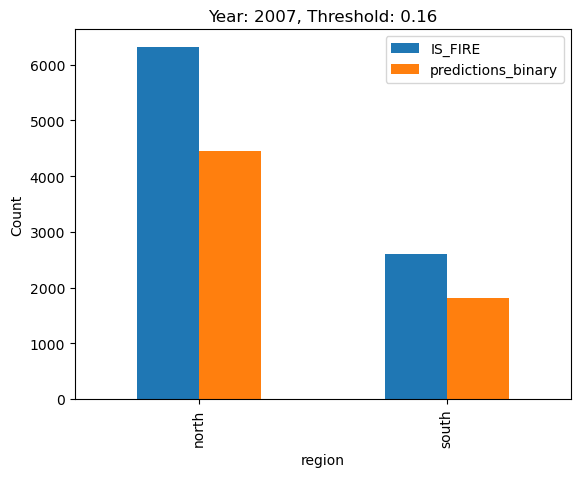

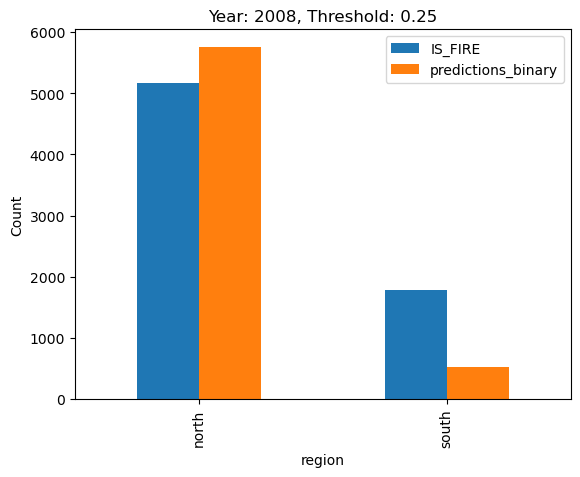

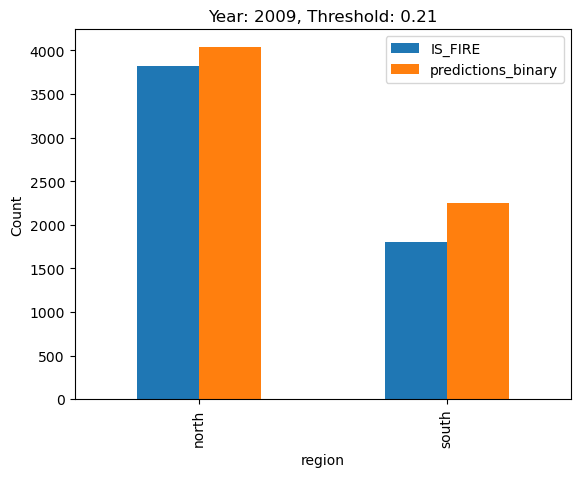

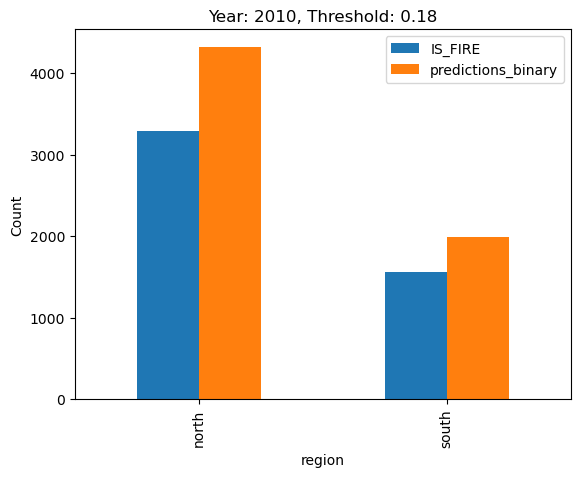

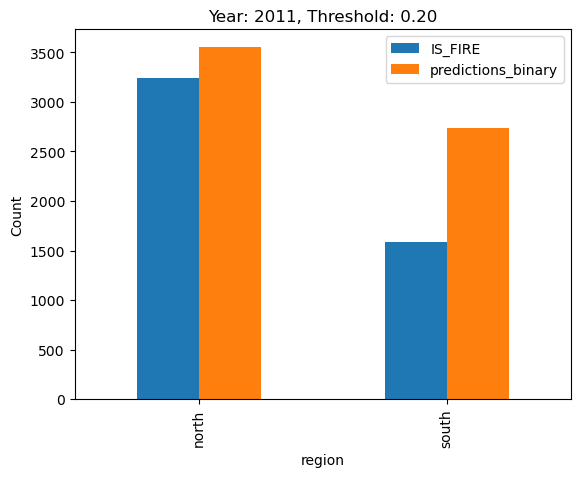

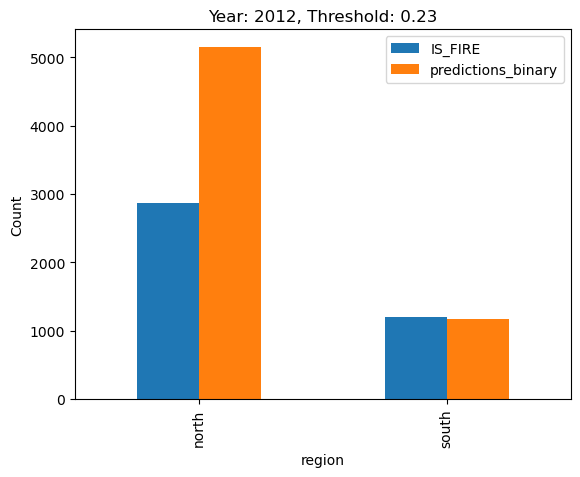

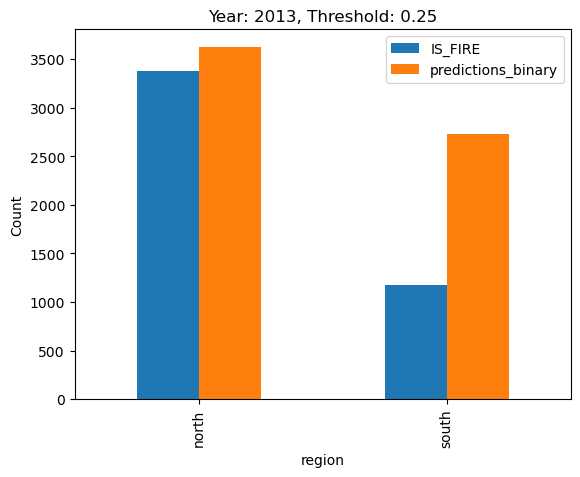

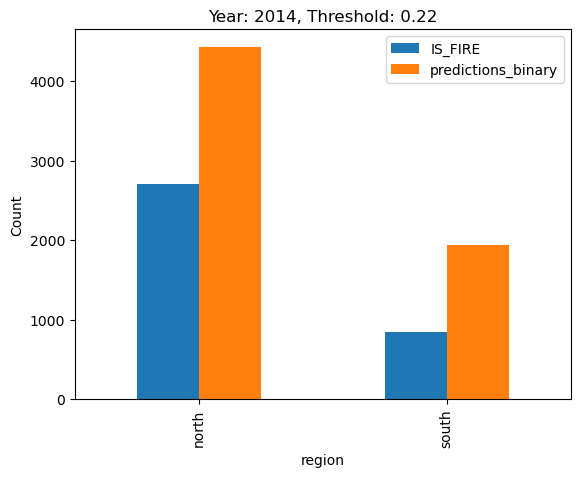

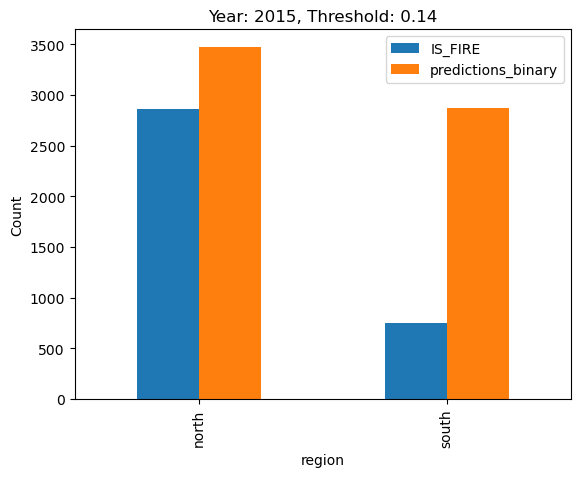

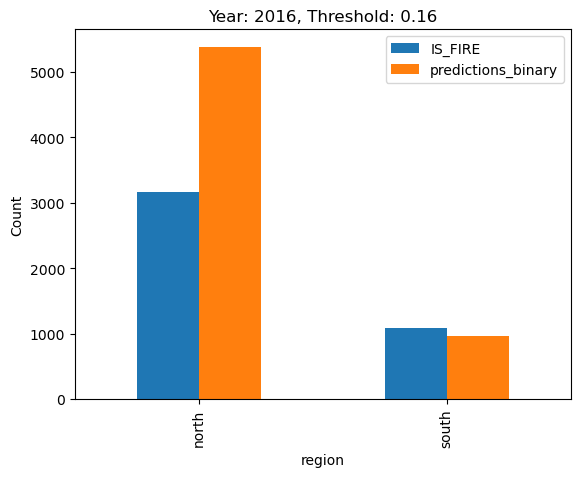

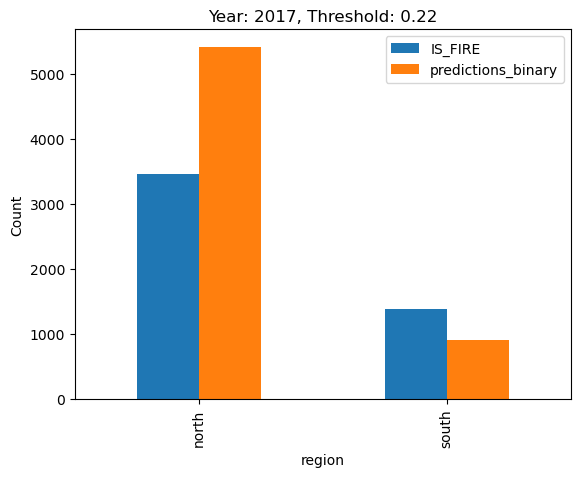

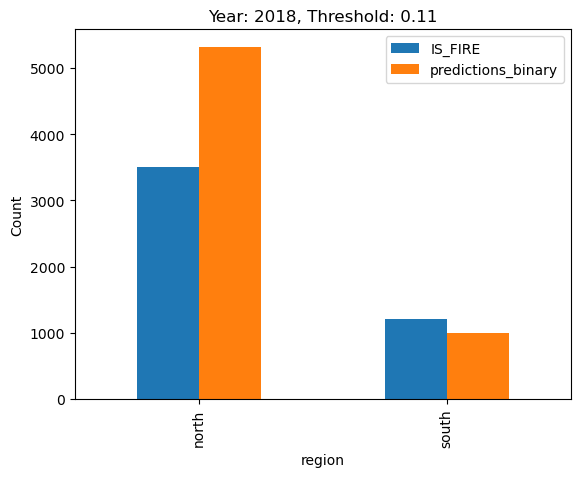

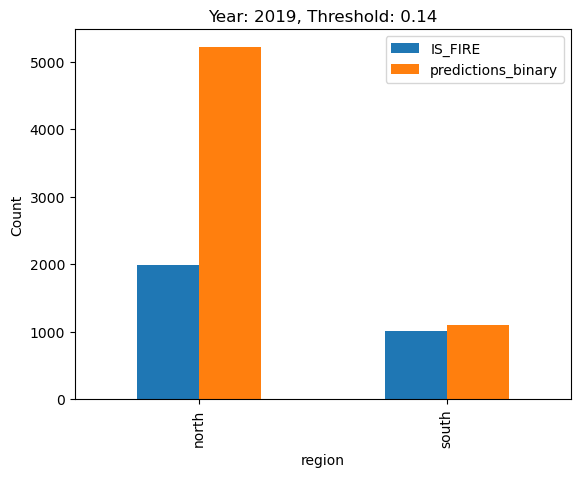

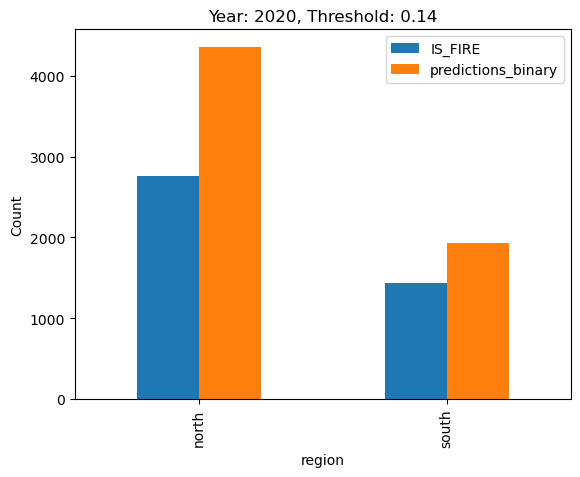

In [94]:
years = range(2007, 2021)


# Calculate the total number of iterations
total_iterations = len(years)

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['predictions'] = mod.predict(dmatrix_eval)
        # assign threshold to be dynamic, 0.99 top percentile
        threshold = np.percentile(Eval_data['predictions'], 99.9)
        Eval_data['predictions_binary'] = (Eval_data['predictions'] > threshold).astype(int)

        # add a column called region
        Eval_data['region'] = np.where(Eval_data['lat'] < 35.75, 'south', 'north')

        # group by region, sum IS_FIRE and sum predictions_binary
        group_dat = Eval_data.groupby('region').agg({'IS_FIRE': 'sum', 'predictions_binary': 'sum'}).reset_index()

        # plot a bar plot, x axis is region, y axis is IS_FIRE and predictions_binary, side by side
        group_dat.plot(x='region', kind='bar', stacked=False)
        # add title to include year and threshold (round to 2 decimal places)
        plt.title(f'Year: {yr}, Threshold: {threshold:.2f}')
        plt.ylabel('Count')
        plt.savefig(f'../Plot/Validate_Region/Validation_Year_{yr}.png')


        # clean the cache
        gc.collect()

        # Update the progress bar
        pbar.update(1)

save data

- previous version didn't contain lat and lon

In [99]:
years = range(2016, 2021)


# Calculate the total number of iterations
total_iterations = len(years)

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['predictions'] = mod.predict(dmatrix_eval)
        # assign threshold to be dynamic, 0.99 top percentile
        threshold = np.percentile(Eval_data['predictions'], 99.9)
        Eval_data['predictions_binary'] = (Eval_data['predictions'] > threshold).astype(int)
        Eval_data.to_csv(f'../Clean_Data/Model_Data/Evaluation/Predictions/{yr}_predictions.csv', index=False)
        # clean the cache
        gc.collect()

        # Update the progress bar
        pbar.update(1)

Processing years: 100%|██████████| 5/5 [20:27<00:00, 245.43s/it]
